# Calibration Simulation

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from plotly import express as px
import plotly.io as pio
# pio.kaleido.scope.mathjax = None  # https://github.com/plotly/plotly.py/issues/3469
from tqdm.auto import tqdm
from calibration import HistogramCalibrator, ScalingBinningCalibrator, OracleCalibrator, BinnedOracleCalibrator, PlattCalibrator, IsotonicCalibrator
from simulation_data import GaussianMixtureData, BetaCalibrationData, GaussianMixtureData2
from simulation_calibration import CalibrationSimulation
%load_ext autoreload
%autoreload 2

## Appendix E.1. Verifying risk bounds of UMB

In [10]:
data = GaussianMixtureData()
sim = CalibrationSimulation(data)
df = sim.run_umb()

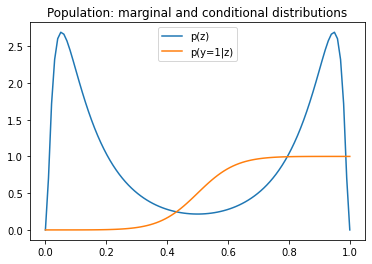

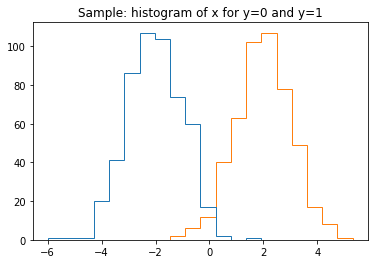

In [12]:
zz = np.linspace(0, 1, 100)
plt.plot(zz, sim.data.pz(zz), label='p(z)')
plt.plot(zz, sim.data.py_given_z(zz), label='p(y=1|z)')
plt.legend()
plt.title('Population: marginal and conditional distributions')
plt.show()

z, y = sim.data.sample(1000)
x = sim.data.f_inv(z)
plt.hist([x[y==0], x[y==1]], histtype='step', stacked=False, bins=20)
plt.title('Sample: histogram of x for y=0 and y=1')
plt.show()

In [13]:
df

cal           sha       ref      risk        bs         n     B  i
0    0.000037  6.333819e-03  0.017149  0.006370  0.023520      1000     6  0
1    0.000153  4.092107e-03  0.017149  0.004245  0.021394      1000     6  1
2    0.000084  1.418198e-02  0.017149  0.014266  0.031415      1000     6  2
3    0.000085  4.906730e-03  0.017149  0.004991  0.022141      1000     6  3
4    0.000437  1.698114e-02  0.017149  0.017418  0.034567      1000     6  4
..        ...           ...       ...       ...       ...       ...   ... ..
495  0.000001  9.516113e-07  0.017149  0.000002  0.017152  10000000  1000  5
496  0.000002  1.055883e-06  0.017149  0.000003  0.017152  10000000  1000  6
497  0.000001  9.338333e-07  0.017149  0.000002  0.017152  10000000  1000  7
498  0.000001  9.895469e-07  0.017149  0.000002  0.017152  10000000  1000  8
499  0.000002  8.869299e-07  0.017149  0.000003  0.017153  10000000  1000  9

[500 rows x 8 columns]

cal vs. B 0.9744885578239817
cal vs. n -0.9853352102563802
sha vs. B -1.8311808737753643


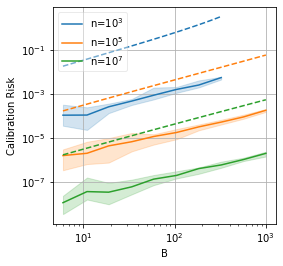

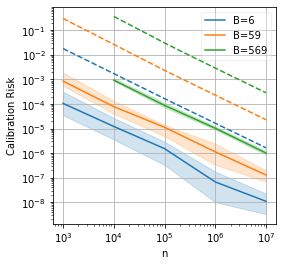

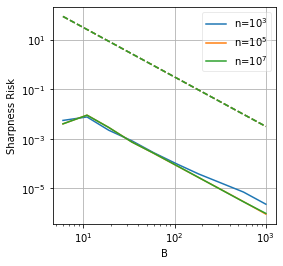

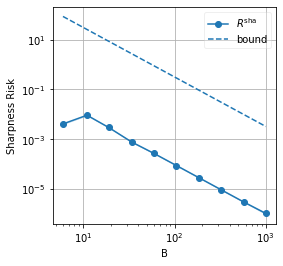

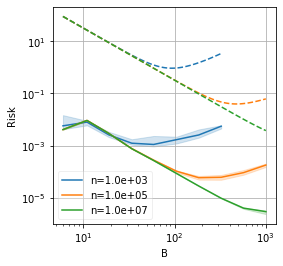

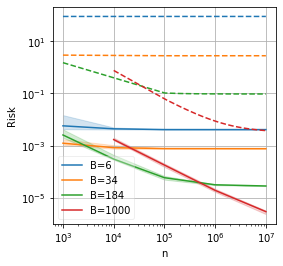

<Figure size 288x288 with 0 Axes>

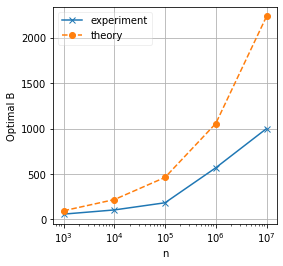

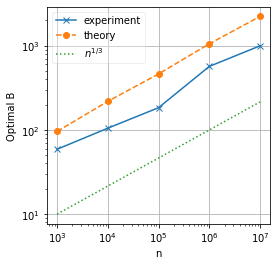

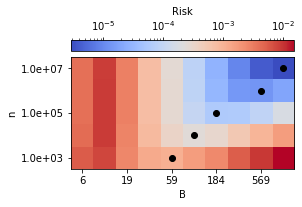

In [17]:
sim.plot_umb(df)

## Appendix E.2. Compare with other recalibration methods
Methods: Platt Scaling, Scaling-binning (Kumar'19), UWB, and UMB

### Simulation 1: Mixture of Gaussians (ommited in the paper)
$$
    \begin{aligned}
    Y &\sim \text{Bernoulli}(0.5), \\
    X \mid Y=0 &\sim \mathcal{N}(-2, 1), \\
    X \mid Y=1 &\sim \mathcal{N}(2, 1), \\
    Z &= \text{sigmoid}(X).
    \end{aligned}
$$


In [19]:
n = 5000
sim = CalibrationSimulation(data=GaussianMixtureData())
df = sim.run_calibrators(n_list=[n], B_list=np.logspace(1, 3.3, 7, dtype=int), i_list=np.arange(1))
df

Calibrator Metric         Value     n     B  i
0      Optimal    cal  0.000000e+00  5000    10  0
1      Optimal    sha  0.000000e+00  5000    10  0
2      Optimal    ref  1.714935e-02  5000    10  0
3      Optimal   risk  0.000000e+00  5000    10  0
4      Optimal     bs  1.714935e-02  5000    10  0
..         ...    ...           ...   ...   ... ..
170        UMB    cal  4.896681e-03  5000  1995  0
171        UMB    sha  4.949775e-07  5000  1995  0
172        UMB    ref  1.714935e-02  5000  1995  0
173        UMB   risk  4.897176e-03  5000  1995  0
174        UMB     bs  2.204653e-02  5000  1995  0

[175 rows x 6 columns]

In [21]:
fig = sim.plot_calibrators(df)
fig

In [23]:
B = round(n ** (1/3))
print(B)
df_raw = sim.run_calibrators(n_list=[5000], B_list=[B], i_list=np.arange(100))

17


In [25]:
df_wide, df_str = sim.tabulate_calibrators(df_raw)
print(df_str)
df_wide

\begin{tabular}{ccccc}
\toprule
Metric ($\times 10^{-3}$) & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & \bfseries 0.062 & \bfseries 0.000 & \bfseries 0.062 & \bfseries 17.212 \\
Hybrid & 0.087 & 4.284 & 4.345 & 21.494 \\
UWB & 0.312 & 0.195 & 0.507 & 17.656 \\
UMB & 0.173 & 4.284 & 4.363 & 21.513 \\
\bottomrule
\end{tabular}



Metric ($\times 10^{-3}$)    $\REL$   $\GRP$       $R$        MSE
Platt                      0.062234  0.00000  0.062234  17.211587
Hybrid                     0.086634  4.28411  4.345000  21.494352
UWB                        0.311842  0.19496  0.506802  17.656155
UMB                        0.172857  4.28411  4.363205  21.512557

### Simulation 2: Logistic calibration
$$
    \begin{aligned}
    Z &\sim \text{Uniform}[0,1], \\
    Y \mid Z &\sim \text{Bernoulli}(h_{\text{beta}}(Z; 4, 4, 0)),
    \end{aligned}
$$
where
$$
    h_{\text{beta}}(z; a, b, c) = \frac{1}{1 + 1/\left(e^c \frac{z^a}{(1-z)^b}\right)}.
$$

#### Risk vs. B

In [27]:
n = 5000
sim = CalibrationSimulation(data=BetaCalibrationData(a=4, b=4, c=0))
df = sim.run_calibrators(n_list=[n], B_list=np.logspace(1, 3.3, 7, dtype=int), i_list=np.arange(1))
df

Calibrator Metric         Value     n     B  i
0      Optimal    cal  0.000000e+00  5000    10  0
1      Optimal    sha  0.000000e+00  5000    10  0
2      Optimal    ref  5.965853e-02  5000    10  0
3      Optimal   risk  0.000000e+00  5000    10  0
4      Optimal     bs  5.965853e-02  5000    10  0
..         ...    ...           ...   ...   ... ..
170        UMB    cal  2.206503e-02  5000  1995  0
171        UMB    sha  1.253362e-07  5000  1995  0
172        UMB    ref  5.965853e-02  5000  1995  0
173        UMB   risk  2.206516e-02  5000  1995  0
174        UMB     bs  8.172369e-02  5000  1995  0

[175 rows x 6 columns]

In [29]:
fig = sim.plot_calibrators(df)
fig.write_image('compare_B_logistic.pdf')
fig

#### Fix B and run random seeds to get 90-percentile

In [30]:
n = 5000
B = round(2 * n ** (1/3))  # UMB have optimal B, yet still underperforming than Hybrid
print(B)
df_raw = sim.run_calibrators(n_list=[5000], B_list=[B], i_list=np.arange(100))

34


In [32]:
df_wide, df_str = sim.tabulate_calibrators(df_raw)
print(df_str)
df_wide

\begin{tabular}{ccccc}
\toprule
Metric ($\times 10^{-3}$) & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 0.122 & \bfseries 0.000 & \bfseries 0.122 & \bfseries 59.781 \\
Hybrid & \bfseries 0.119 & 0.212 & 0.315 & 59.974 \\
UWB & 0.661 & 0.194 & 0.855 & 60.514 \\
UMB & 0.647 & 0.212 & 0.839 & 60.497 \\
\bottomrule
\end{tabular}



Metric ($\times 10^{-3}$)    $\REL$    $\GRP$       $R$        MSE
Platt                      0.122294  0.000000  0.122294  59.780824
Hybrid                     0.118659  0.212339  0.315471  59.974002
UWB                        0.661395  0.193874  0.855270  60.513800
UMB                        0.646514  0.212339  0.838940  60.497471

#### Fix B and random seed to plot

/x/home/zeyusun/work/wip/simulation_data.py:101: RuntimeWarning:

divide by zero encountered in true_divide



  0%|          | 0/5 [00:00<?, ?it/s]

Metric    $\REL$    $\GRP$       $R$       MSE
Platt   0.000015  0.000000  0.000015  0.059674
Hybrid  0.000014  0.000199  0.000213  0.059872
UWB     0.000499  0.000194  0.000693  0.060351
UMB     0.000546  0.000199  0.000745  0.060404

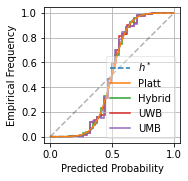

In [38]:
# B = round(2 * n ** (1/3))  # we might prefer small B for visualization
plt.figure(figsize=(2.5, 2.5))
df_wide, df_str, _ = sim.run_calibrators_single(n=n, B=B, seed=3)
plt.savefig('compare_rd_logistic.pdf', bbox_inches='tight')
df_wide

### Simulation 3: Beta calibration
$$
    \begin{aligned}
    Z &\sim \text{Uniform}[0,1], \\
    Y \mid Z &\sim \text{Bernoulli}(h_{\text{beta}}(Z; 0.1, 4, 0)).
    \end{aligned}
$$

#### Risk vs. B

In [39]:
sim = CalibrationSimulation(data=BetaCalibrationData(a=0.1, b=4, c=0)) #m=0.25)
n = 5000
df = sim.run_calibrators(n_list=[n], B_list=np.logspace(1, 3.3, 7, dtype=int), i_list=np.arange(1))
df

Calibrator Metric         Value     n     B  i
0      Optimal    cal  0.000000e+00  5000    10  0
1      Optimal    sha  0.000000e+00  5000    10  0
2      Optimal    ref  9.593936e-02  5000    10  0
3      Optimal   risk  0.000000e+00  5000    10  0
4      Optimal     bs  9.593936e-02  5000    10  0
..         ...    ...           ...   ...   ... ..
170        UMB    cal  3.814027e-02  5000  1995  0
171        UMB    sha  2.388373e-07  5000  1995  0
172        UMB    ref  9.593936e-02  5000  1995  0
173        UMB   risk  3.814051e-02  5000  1995  0
174        UMB     bs  1.340799e-01  5000  1995  0

[175 rows x 6 columns]

In [40]:
fig = sim.plot_calibrators(df)
fig.write_image('compare_B_beta.pdf')
fig

#### Fix B and run random seeds to get 90-percentile

In [41]:
B = round(n ** (1/3))
print(B)
df_raw = sim.run_calibrators(n_list=[n], B_list=[B], i_list=np.arange(100))

17


In [42]:
df_wide, df_str = sim.tabulate_calibrators(df_raw)
print(df_str)
df_wide

\begin{tabular}{ccccc}
\toprule
Metric ($\times 10^{-3}$) & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 3.682 & \bfseries 0.000 & 3.682 & 99.621 \\
Hybrid & 3.117 & 0.251 & 3.360 & 99.299 \\
UWB & 0.572 & 0.238 & 0.810 & 96.749 \\
UMB & \bfseries 0.560 & 0.251 & \bfseries 0.797 & \bfseries 96.736 \\
\bottomrule
\end{tabular}



Metric ($\times 10^{-3}$)    $\REL$    $\GRP$       $R$        MSE
Platt                      3.681965  0.000000  3.681965  99.621327
Hybrid                     3.117253  0.251361  3.359704  99.299065
UWB                        0.572079  0.237797  0.809876  96.749238
UMB                        0.559846  0.251361  0.797110  96.736471

#### Fix B and random seed to plot

/x/home/zeyusun/work/wip/simulation_data.py:101: RuntimeWarning:

divide by zero encountered in true_divide



  0%|          | 0/5 [00:00<?, ?it/s]

\begin{tabular}{ccccc}
\toprule
Metric & $\REL$ & $\GRP$ & $R$ & MSE \\
\midrule
Platt & 0.003409 & \bfseries 0.000000 & 0.003409 & 0.099348 \\
Hybrid & 0.002939 & 0.000234 & 0.003173 & 0.099112 \\
UWB & 0.000155 & 0.000238 & 0.000392 & 0.096332 \\
UMB & \bfseries 0.000134 & 0.000234 & \bfseries 0.000368 & \bfseries 0.096307 \\
\bottomrule
\end{tabular}



Metric    $\REL$    $\GRP$       $R$       MSE
Platt   0.003409  0.000000  0.003409  0.099348
Hybrid  0.002939  0.000234  0.003173  0.099112
UWB     0.000155  0.000238  0.000392  0.096332
UMB     0.000134  0.000234  0.000368  0.096307

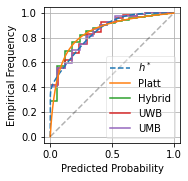

In [43]:
plt.figure(figsize=(2.5, 2.5))
df_wide, df_str, _ = sim.run_calibrators_single(n=n, B=B, seed=0)
plt.savefig('compare_rd_beta.pdf', bbox_inches='tight')
print(df_str)
df_wide

## Different distributions

## Different classifiers

In [39]:
# sim = CalibrationSimulation(data=GaussianMixtureData(mu=1, p=0.1))
sim = CalibrationSimulation(data=GaussianMixtureData2())

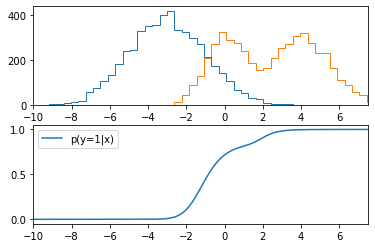

In [2]:
x, y = data.sample(10000)
xlim = [-10, 7.5]

fig, ax = plt.subplots(2, 1)
ax[0].hist([x[y==0], x[y==1]], histtype='step', stacked=False, bins=50)
ax[0].set_xlim(xlim)

xx = np.linspace(*xlim, 1000)
ax[1].plot(xx, data.py_given_x(xx), label='p(y=1|x)')
ax[1].set_xlim(xlim)
plt.legend()

In [7]:
df = sim.run_classifiers(
    n_list=np.logspace(3, 7, 5, dtype=int),
    B_list=np.logspace(1, 4, 7, dtype=int),
    i_list=np.arange(5)
)

Decision Tree
cal vs. B 0.02592107671129633


/home/zeyusun/calibration_private/simulation_calibration.py:68: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_lower = df_raw.groupby(['n', 'B']).quantile(q=delta)
/home/zeyusun/calibration_private/simulation_calibration.py:69: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_upper = df_raw.groupby(['n', 'B']).quantile(q=1-delta)


cal vs. n -0.9407702286292637
sha vs. B -0.1494004478885085
Gradient Boosting
cal vs. B 0.27504738542855


/home/zeyusun/calibration_private/simulation_calibration.py:68: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_lower = df_raw.groupby(['n', 'B']).quantile(q=delta)
/home/zeyusun/calibration_private/simulation_calibration.py:69: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_upper = df_raw.groupby(['n', 'B']).quantile(q=1-delta)


cal vs. n -0.9493311008607623
sha vs. B -0.7030221823122708
Logistic
cal vs. B 0.6667591260165955


/home/zeyusun/calibration_private/simulation_calibration.py:68: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_lower = df_raw.groupby(['n', 'B']).quantile(q=delta)
/home/zeyusun/calibration_private/simulation_calibration.py:69: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_upper = df_raw.groupby(['n', 'B']).quantile(q=1-delta)
/home/zeyusun/calibration_private/simulation_calibration.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max

cal vs. n -0.8679013820129433
sha vs. B -0.6859215632177007
Naive Bayes
cal vs. B 0.6667512698758296


/home/zeyusun/calibration_private/simulation_calibration.py:68: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_lower = df_raw.groupby(['n', 'B']).quantile(q=delta)
/home/zeyusun/calibration_private/simulation_calibration.py:69: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  df_upper = df_raw.groupby(['n', 'B']).quantile(q=1-delta)


cal vs. n -0.8678969360046336
sha vs. B -0.6859215632177007


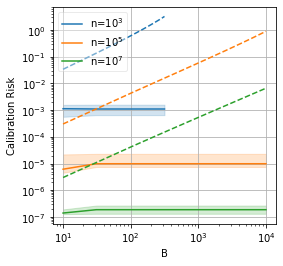

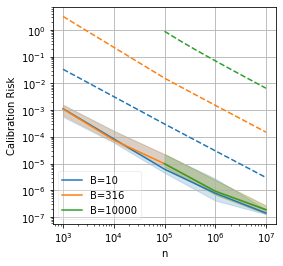

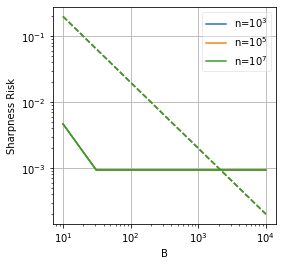

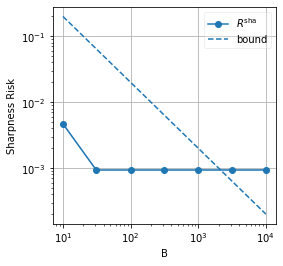

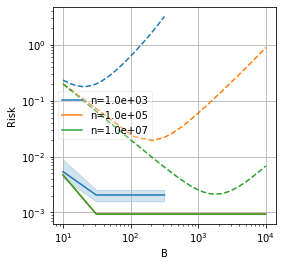

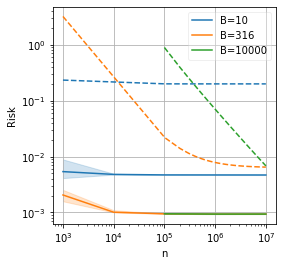

<Figure size 288x288 with 0 Axes>

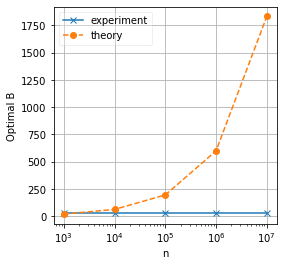

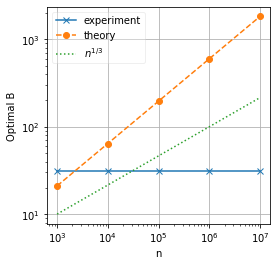

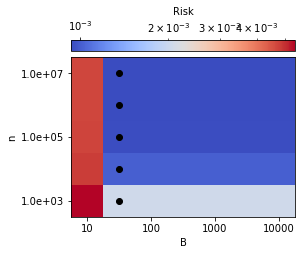

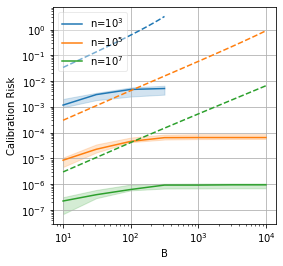

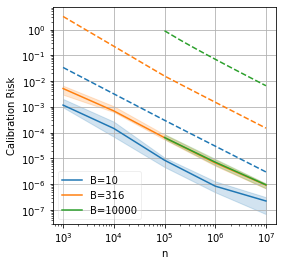

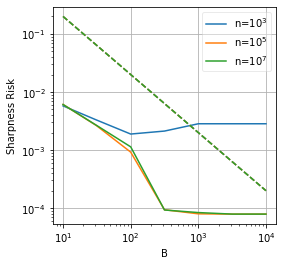

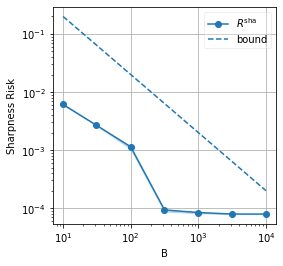

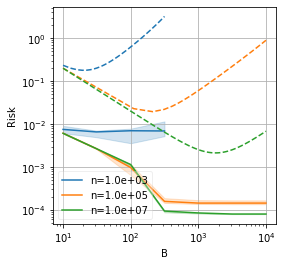

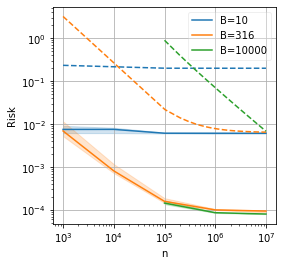

<Figure size 288x288 with 0 Axes>

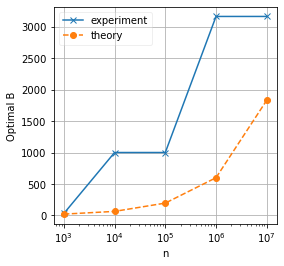

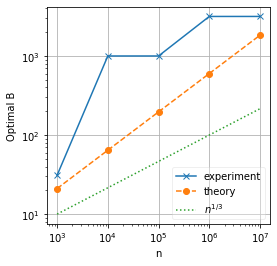

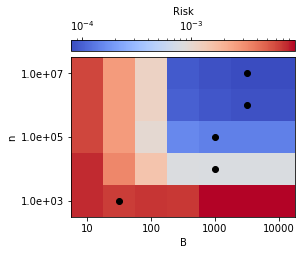

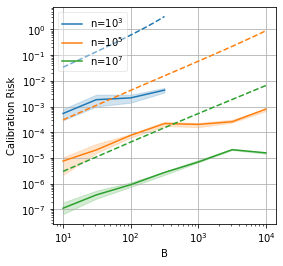

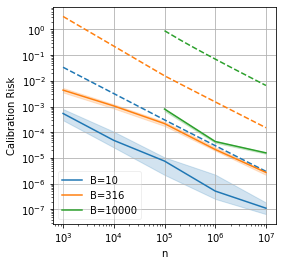

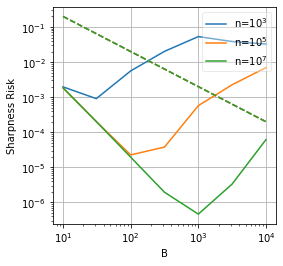

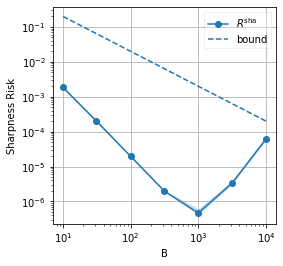

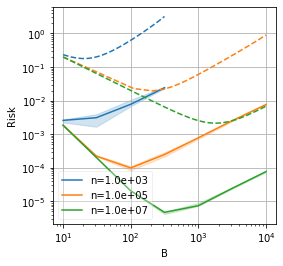

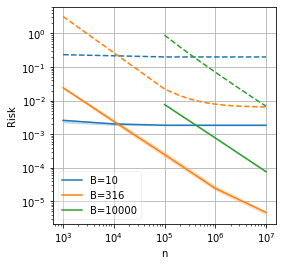

<Figure size 288x288 with 0 Axes>

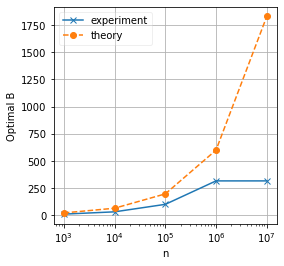

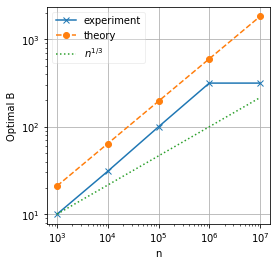

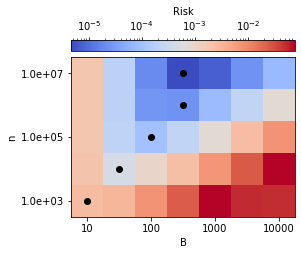

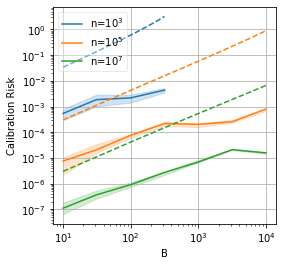

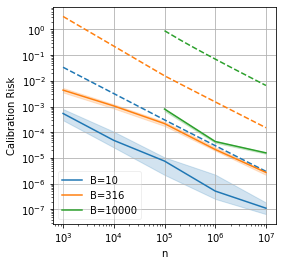

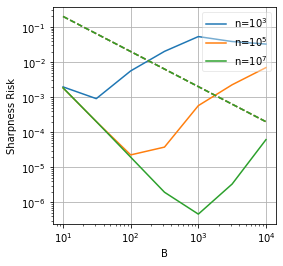

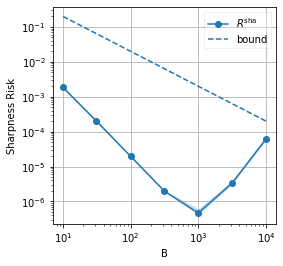

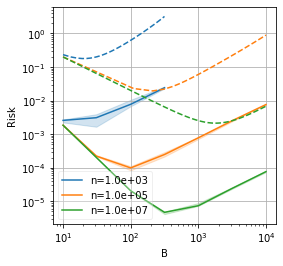

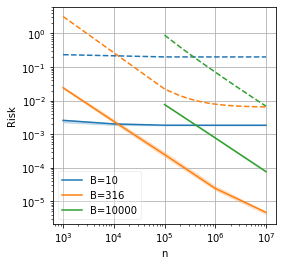

<Figure size 288x288 with 0 Axes>

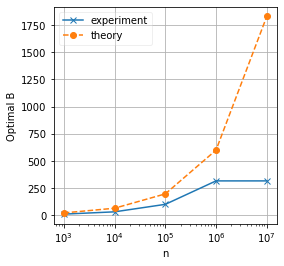

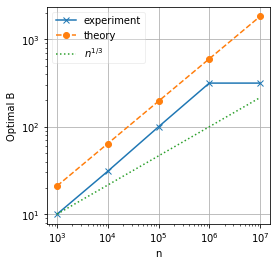

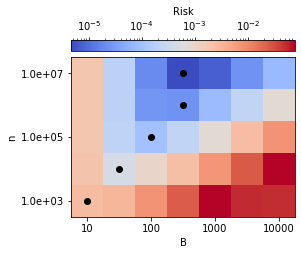

In [9]:
for clf_name in np.unique(df['classifier']):
    print(clf_name)
    sim.plot_classifiers(df[df['classifier'] == clf_name], folder=clf_name)

#### Inspect different classfiers for one set of (n,B)

In [4]:
from simulation_calibration import evaluate_sample

n = 10000
B = 100
i = 0

sim = CalibrationSimulation(data=data)
sim.run_classifiers_prepare()

x_cal, y_cal = sim.data.sample(n, 'xy')
x_test, y_test = sim.data.sample(10**7, 'xy')
results = []
calibrators = {}
for clf_name, clf in tqdm(sim.classifiers.items()):
    calibrator = HistogramCalibrator(n_bins=B, strategy='quantile')
    calibrator.fit(clf.predict_proba(x_cal.reshape(-1, 1))[:, 1], y_cal)
    calibrators[clf_name] = calibrator

    z_pred = calibrator.predict(clf.predict_proba(x_test.reshape(-1, 1))[:, 1])
    z_true = sim.data.py_given_x(x_test)
    metrics = evaluate_sample(z_pred, z_true, y=y_test)
    metrics.update({'n': n, 'B': B, 'i': i, 'classifier': clf_name})
    results.append(metrics)

  0%|          | 0/4 [00:00<?, ?it/s]

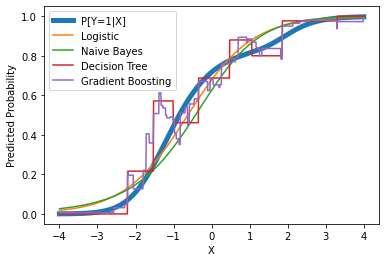

In [5]:
xx = np.linspace(-4, 4, 1000)
plt.plot(xx, sim.data.py_given_x(xx), label='P[Y=1|X]', lw=5)
for clf_name, clf in sim.classifiers.items():
    plt.plot(xx, clf.predict_proba(xx.reshape(-1,1))[:,1], label=clf_name)
plt.xlabel('X')
plt.ylabel('Predicted Probability')
plt.legend()

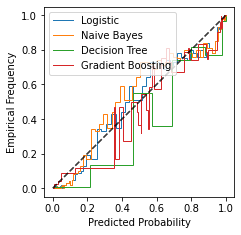

In [12]:
for name, calibrator in calibrators.items():
    calibrator.plot(label=name, set_layout=True)
# OracleCalibrator(sim.data.py_given_z).plot()
plt.legend(loc='upper left')